In [ ]:
# Rock Facies Classification with XGBoost and Physics Motivated Feature Augmentation
# Yu Zeng (10/29/2018)

In [1]:
# Test ref: Use 7 features: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS'
#     --> F1 score: 0.59
# Test 0: Use 8 features: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoPhi'
#     --> F1 score: 0.62
# Test 1: Use 9 features: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoPhi','ILDoLogPhi'
#     --> F1 score: 0.62
# Test 2: Use 8 features: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoLogPhi'
#     --> F1 score: 0.60
# Test 3: Use 9 features: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoPhi','PEoDeltaPHI'
#     --> F1 score: 0.61
# Test 4: Use 8 features but add 2nd derivative: 'GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoPhi'
#     --> F1 Score: 0.58

In [2]:
import pandas as pd
import numpy as np 
data = pd.read_csv('training_data.csv')  

In [3]:
#data['ILDoLogPhi'] = data['ILD_log10'] / pd.np.log10(data['PHIND'])
data['ILDoLogPhi'] = data['ILD_log10'] / data['PHIND']
data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ILDoLogPhi
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,0.055728
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,0.052606
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,0.050421
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,0.049943
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,0.048647
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894,0.047516
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872,0.045226
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830,0.044899
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809,0.044635
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787,0.043249


In [4]:
data_test = data[data['Well Name'] == 'SHANKLE']
data = data[data['Well Name'] != 'SHANKLE']

In [5]:
print(data_test.shape, data.shape)

(449, 12) (2783, 12)


In [6]:
features1 = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS']   # Test ref
features2 = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoLogPhi']           # Test 2

feature_vectors1 = data[features1]
facies_labels1 = data['Facies']
feature_vectors1_test = data_test[features1]
facies_labels1_test = data_test['Facies']

feature_vectors2 = data[features2]
facies_labels2 = data['Facies']
feature_vectors2_test = data_test[features2]
facies_labels2_test = data_test['Facies']


facies_labels1.describe()
# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values
well_test = data_test['Well Name'].values
depth_test = data_test['Depth'].values
# Fill 'PE' missing values with mean
from sklearn import preprocessing
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(feature_vectors1)
print("Before transform: feature_vectors1.shape = ", feature_vectors1.shape)
feature_vectors1 = imp.transform(feature_vectors1)
print("After transform: feature_vectors.shape = ", feature_vectors1.shape)
imp.fit(feature_vectors1_test)
feature_vectors1_test = imp.transform(feature_vectors1_test)

imp.fit(feature_vectors2)
print("Before transform: feature_vectors1.shape = ", feature_vectors2.shape)
feature_vectors2 = imp.transform(feature_vectors2)
print("After transform: feature_vectors.shape = ", feature_vectors2.shape)
imp.fit(feature_vectors2_test)
feature_vectors2_test = imp.transform(feature_vectors2_test)


#imp2 = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
#print('fit_transform', imp2.fit_transform(feature_vectors0).shape)


Before transform: feature_vectors1.shape =  (2783, 7)
After transform: feature_vectors.shape =  (2783, 7)
Before transform: feature_vectors1.shape =  (2783, 8)
After transform: feature_vectors.shape =  (2783, 8)


In [7]:
print(len(features1),feature_vectors1.shape, feature_vectors1_test.shape)
print(len(features2),feature_vectors2.shape, feature_vectors2_test.shape)

7 (2783, 7) (449, 7)
8 (2783, 8) (449, 8)


In [8]:
print('feature_vectors1:', feature_vectors1)
print('feature_vectors2:', feature_vectors2)

feature_vectors1: [[77.45   0.664  9.9   ...  4.6    1.     1.   ]
 [78.26   0.661 14.2   ...  4.1    1.     0.979]
 [79.05   0.658 14.8   ...  3.6    1.     0.957]
 ...
 [49.719  0.964  2.925 ...  3.19   2.     0.669]
 [51.469  0.965  3.083 ...  3.152  2.     0.661]
 [50.031  0.97   2.609 ...  3.295  2.     0.653]]
feature_vectors2: [[7.74500000e+01 6.64000000e-01 9.90000000e+00 ... 1.00000000e+00
  1.00000000e+00 5.57280739e-02]
 [7.82600000e+01 6.61000000e-01 1.42000000e+01 ... 1.00000000e+00
  9.79000000e-01 5.26064465e-02]
 [7.90500000e+01 6.58000000e-01 1.48000000e+01 ... 1.00000000e+00
  9.57000000e-01 5.04214559e-02]
 ...
 [4.97190000e+01 9.64000000e-01 2.92500000e+00 ... 2.00000000e+00
  6.69000000e-01 1.20304505e-01]
 [5.14690000e+01 9.65000000e-01 3.08300000e+00 ... 2.00000000e+00
  6.61000000e-01 1.25194603e-01]
 [5.00310000e+01 9.70000000e-01 2.60900000e+00 ... 2.00000000e+00
  6.53000000e-01 1.45470906e-01]]


In [9]:



# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
#def augment_features(X, well, depth, N_neig=0):   

    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

# Feature 2nd derivative computation function
def augment_features_2nd_derivative(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    # Compute feature gradient on X_grad
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X_grad, axis=0)
    X_grad2 = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad2 = np.concatenate((X_grad2, np.zeros((1, X_grad2.shape[1]))))
    
    return X_grad2

# Feature augmentation function 2
def augment_features2(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+3)))  # N_neig*2 +2 --> N_neig*2 + 3
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug_2nd_derivative = augment_features_2nd_derivative(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad, X_aug_2nd_derivative), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [10]:
print('feature_vectors1.shape:', feature_vectors1.shape[1])
print('feature_vectors2.shape:', feature_vectors2.shape[1])

feature_vectors1.shape: 7
feature_vectors2.shape: 8


In [11]:
X_aug1, padded_rows1 = augment_features(feature_vectors1, well, depth)
X_aug1_test, padded_rows1_test = augment_features(feature_vectors1_test, well_test, depth_test)

X_aug2, padded_rows2 = augment_features(feature_vectors2, well, depth)
X_aug2_test, padded_rows2_test = augment_features(feature_vectors2_test, well_test, depth_test)

# below add 2nd derivative
#X_aug, padded_rows = augment_features2(feature_vectors, well, depth)
#X_aug_test, padded_rows_test = augment_features2(feature_vectors_test, well_test, depth_test)

print('X_aug1.shape = ', X_aug1.shape, 'X_aug1_test.shape = ', X_aug1_test.shape)
print('X_aug2.shape = ', X_aug2.shape, 'X_aug2_test.shape = ', X_aug2_test.shape)

X_aug1.shape =  (2783, 28) X_aug1_test.shape =  (449, 28)
X_aug2.shape =  (2783, 32) X_aug2_test.shape =  (449, 32)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_aug1)
scaled_features1 = scaler.transform(X_aug1) #ndarray now. 
scaler1_test = StandardScaler().fit(X_aug1_test)
scaled_features1_test = scaler.transform(X_aug1_test) #ndarray now. 
print('scaled_features1.shape', scaled_features1.shape)

scaler = StandardScaler().fit(X_aug2)
scaled_features2 = scaler.transform(X_aug2) #ndarray now. 
scaler2_test = StandardScaler().fit(X_aug2_test)
scaled_features2_test = scaler.transform(X_aug2_test) #ndarray now. 
print('scaled_features2.shape', scaled_features2.shape)

scaled_features1.shape (2783, 28)
scaled_features2.shape (2783, 32)


In [13]:
from sklearn.model_selection import train_test_split
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(scaled_features1, facies_labels1,test_size=0.05, random_state=42,stratify=facies_labels1)
print('X_train1.shape', X_train1.shape)

X_train2, X_cv2, y_train2, y_cv2 = train_test_split(scaled_features2, facies_labels2,test_size=0.05, random_state=42,stratify=facies_labels2)
print('X_train2.shape', X_train2.shape)

#X_train, X_cv, y_train, y_cv = train_test_split(scaled_features, facies_labels,test_size=0.05, random_state=42)
#y_train.value_counts()

X_train1.shape (2643, 28)
X_train2.shape (2643, 32)


In [14]:
from sklearn.metrics import classification_report
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS', 'BS']

In [15]:
# // SVM
#from sklearn import svm
#clf = svm.SVC(C=10, gamma=1)
# // XGboost
from xgboost.sklearn import  XGBClassifier
clf1 = XGBClassifier(learning_rate=0.12,max_depth=3,min_child_weight=10,n_estimators=150,seed=100,colsample_bytree=0.9)
# // MLP
#from sklearn.neural_network import MLPClassifier
#clf = MLPClassifier(solver='lbfgs', alpha=1e-1,hidden_layer_sizes=(3), random_state=1)
clf1.fit(X_train1, y_train1)

clf2 = XGBClassifier(learning_rate=0.12,max_depth=3,min_child_weight=10,n_estimators=150,seed=100,colsample_bytree=0.9)
clf2.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1)

In [16]:
y_cv1_pred = clf1.predict(X_cv1) 
print('Benchmark:')
print(classification_report(y_cv1, y_cv1_pred,target_names=target_names))

y_cv2_pred = clf2.predict(X_cv2) 
print('Our approach:')
print(classification_report(y_cv2, y_cv2_pred,target_names=target_names))

Benchmark:
             precision    recall  f1-score   support

         SS       0.88      0.88      0.88         8
       CSiS       0.74      0.85      0.79        33
       FSiS       0.81      0.68      0.74        25
       SiSh       0.45      0.56      0.50         9
         MS       0.62      0.50      0.56        10
         WS       0.76      0.65      0.70        20
          D       0.75      0.75      0.75         4
         PS       0.62      0.70      0.65        23
         BS       0.86      0.75      0.80         8

avg / total       0.72      0.71      0.71       140

Our approach:
             precision    recall  f1-score   support

         SS       0.88      0.88      0.88         8
       CSiS       0.76      0.85      0.80        33
       FSiS       0.82      0.72      0.77        25
       SiSh       0.50      0.56      0.53         9
         MS       0.56      0.50      0.53        10
         WS       0.74      0.70      0.72        20
          D      

C:\Users\HomeUser\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HomeUser\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
y_pred1 = clf1.predict(scaled_features1_test)
y_pred2 = clf2.predict(scaled_features2_test)

C:\Users\HomeUser\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HomeUser\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
print('Benchmark:')
print(classification_report(facies_labels1_test, y_pred1,target_names=target_names))
print('Our approach:')
print(classification_report(facies_labels2_test, y_pred2,target_names=target_names))

Benchmark:
             precision    recall  f1-score   support

         SS       0.78      0.39      0.52        89
       CSiS       0.42      0.82      0.56        89
       FSiS       0.83      0.56      0.67       117
       SiSh       0.15      0.43      0.22         7
         MS       0.00      0.00      0.00        19
         WS       0.72      0.75      0.73        71
          D       0.90      0.53      0.67        17
         PS       0.67      0.70      0.68        40

avg / total       0.66      0.59      0.59       449

Our approach:
             precision    recall  f1-score   support

         SS       0.82      0.42      0.55        89
       CSiS       0.42      0.83      0.56        89
       FSiS       0.87      0.56      0.68       117
       SiSh       0.16      0.43      0.23         7
         MS       0.00      0.00      0.00        19
         WS       0.73      0.79      0.76        71
          D       1.00      0.65      0.79        17
         PS      

C:\Users\HomeUser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 9
  .format(len(labels), len(target_names))


In [19]:
# Use confusion matrix to evaluate, by providing actual and predicted facies labels
from sklearn.metrics import confusion_matrix
from confusion_matrix_utilities import plot_confusion_matrix, plot_confusion_matrix2
import matplotlib.pyplot as plt

# Plot un-normalized confusion matrix
# The rows of the confusion matrix correspond to the actual facies labels. 
# The columns correspond to the labels assigned by the classifier. 

# 1=sandstone  2=c_siltstone   3=f_siltstone ​from confusion_matrix_utilities import plot_confusion_matrix
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]


Normalized confusion matrix
[[0.39325843 0.58426966 0.02247191 0.         0.         0.
  0.         0.        ]
 [0.06741573 0.82022472 0.11235955 0.         0.         0.
  0.         0.        ]
 [0.03418803 0.41025641 0.55555556 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.42857143 0.         0.28571429
  0.         0.28571429]
 [0.         0.         0.         0.73684211 0.         0.26315789
  0.         0.        ]
 [0.         0.         0.01408451 0.04225352 0.07042254 0.74647887
  0.         0.12676056]
 [0.         0.         0.         0.         0.11764706 0.17647059
  0.52941176 0.17647059]
 [0.         0.         0.         0.         0.         0.275
  0.025      0.7       ]]


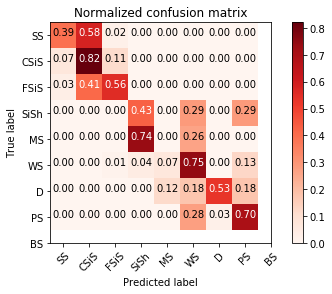

In [20]:
#%matplotlib notebook

# confusion matrix for XGBoost with feature augmentation
conf1 = confusion_matrix(facies_labels1_test, y_pred1)  # confusion matrix 'conf' is 9x9 ndarray (conf.shape)

#print('Benchmark:\n')
fig = plt.figure()
plot_confusion_matrix2(conf1, classes=facies_labels, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('figures/conf_matrix_Shankle_bench_SEG.png', bbox_inches='tight')

Our approach:

Normalized confusion matrix
[[0.41573034 0.57303371 0.01123596 0.         0.         0.
  0.         0.        ]
 [0.06741573 0.83146067 0.08988764 0.         0.01123596 0.
  0.         0.        ]
 [0.01709402 0.42735043 0.55555556 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.42857143 0.         0.28571429
  0.         0.28571429]
 [0.         0.         0.         0.73684211 0.         0.26315789
  0.         0.        ]
 [0.         0.         0.01408451 0.02816901 0.05633803 0.78873239
  0.         0.11267606]
 [0.         0.         0.         0.         0.         0.23529412
  0.64705882 0.11764706]
 [0.         0.         0.         0.         0.         0.25
  0.         0.75      ]]


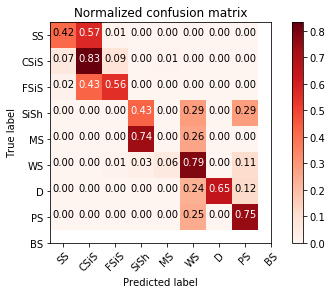

In [42]:
conf2 = confusion_matrix(facies_labels2_test, y_pred2)
print('Our approach:\n')
fig=plt.figure()
plot_confusion_matrix2(conf2, classes=facies_labels, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('figures/conf_matrix_Shankle_our_SEG.png', bbox_inches='tight')

In [22]:
# call well_log_plot_utilities.py 
from well_log_plot_utilities import compare_facies_plot

data_test['benchmark_pred'] = y_pred1
data_test['our_pred'] = y_pred2


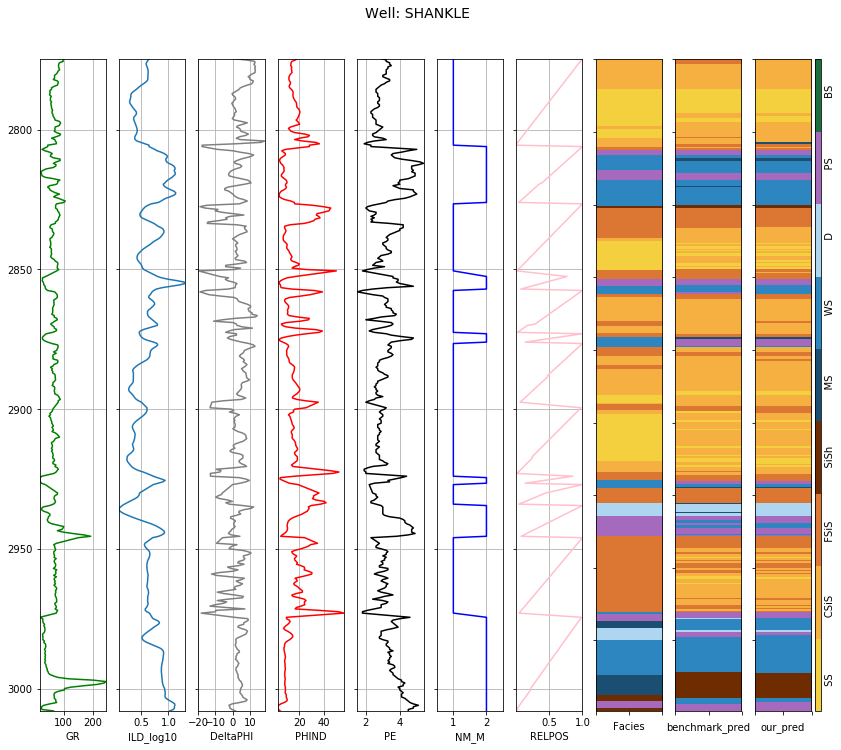

In [23]:
# -------------------------------------------------------------------
# Paper plot, use same color map as SEG machine learning competition
# -------------------------------------------------------------------
from well_log_plot_utilities import compare_facies_plot3
fig=compare_facies_plot3(data_test.sort_values(by='Depth'), 'benchmark_pred', 'our_pred', facies_colors)
#fig.savefig('figures/conf_matrix_Shankle_bench_SEG.png', bbox_inches='tight')


## Check distribution of facies for each well

['SHRIMPLIN' 'SHRIMPLIN' 'SHRIMPLIN' ... 'CHURCHMAN BIBLE'
 'CHURCHMAN BIBLE' 'CHURCHMAN BIBLE']


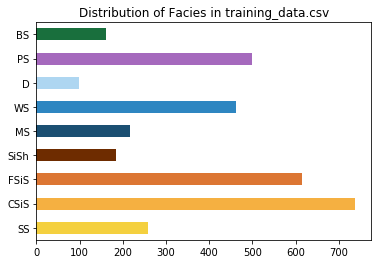

In [58]:
data_raw = pd.read_csv('training_data.csv')
print(data_raw['Well Name'].values)
fig=plt.figure()

facies_count = data_raw['Facies'].value_counts().sort_index()
facies_count.index = facies_labels

facies_count.plot(kind='barh',color=facies_colors, 
                   title='Distribution of Facies in training_data.csv')
fig.savefig('figures/facies_distribution_SEG.png', bbox_inches='tight')


# Verify logF/logPhi or logF/Phi relationship

In [24]:
df_facies_type_1 = data[data['Facies'] == 1]
df_facies_type_2 = data[data['Facies'] == 2]
df_facies_type_3 = data[data['Facies'] == 3]
df_facies_type_4 = data[data['Facies'] == 4]
df_facies_type_5 = data[data['Facies'] == 5]
df_facies_type_6 = data[data['Facies'] == 6]
df_facies_type_7 = data[data['Facies'] == 7]
df_facies_type_8 = data[data['Facies'] == 8]
df_facies_type_9 = data[data['Facies'] == 9]

C:\Users\HomeUser\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


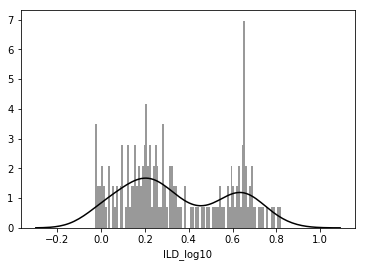

In [25]:
import seaborn as sns

sns.distplot(df_facies_type_1['ILD_log10'], bins=100, color='k')

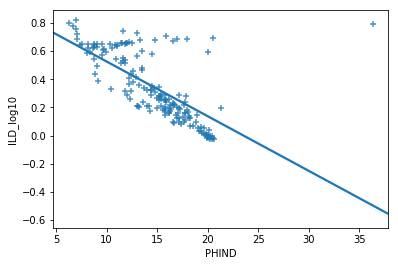

In [26]:
sns.regplot('PHIND', 'ILD_log10', data=df_facies_type_1, ci=1, marker="+")

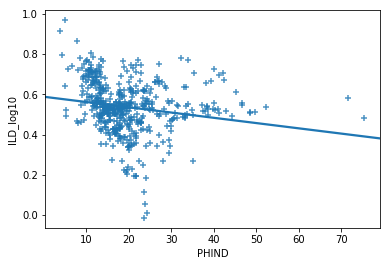

In [27]:
sns.regplot('PHIND', 'ILD_log10', data=df_facies_type_3, ci=1, marker="+")

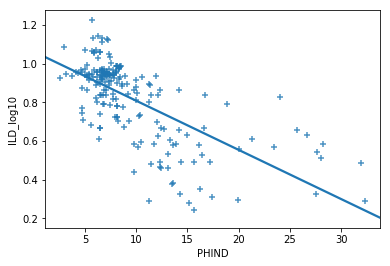

In [28]:
sns.regplot('PHIND', 'ILD_log10', data=df_facies_type_5, ci=1, marker="+")

## Plot fitting curve: ILD_log10 vs. PHIND

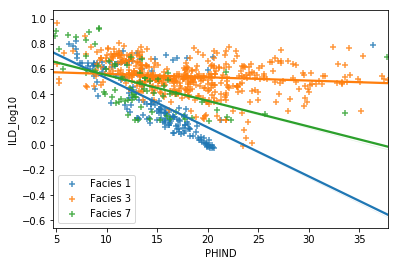

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_ylim([-0.05, 1.50])
sns.regplot(df_facies_type_1['PHIND'], df_facies_type_1['ILD_log10'], marker='+', label='Facies 1', ci=1)
#sns.regplot(df_facies_type_2['PHIND'], df_facies_type_2['ILD_log10'], marker='+', label='Facies 2', ci=1)
sns.regplot(df_facies_type_3['PHIND'], df_facies_type_3['ILD_log10'], marker='+', label='Facies 3', ci=1)
#sns.regplot(df_facies_type_5['PHIND'], df_facies_type_5['ILD_log10'], marker='+', label='Facies 5', ci=1)
sns.regplot(df_facies_type_7['PHIND'], df_facies_type_7['ILD_log10'], marker='+', label='Facies 7', ci=1)
ax.legend(loc='best')

## Plot fitting curve: ILD_log10 vs. PHIND_log10

C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if __name__ == '__main__':
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  del sys.path[0]


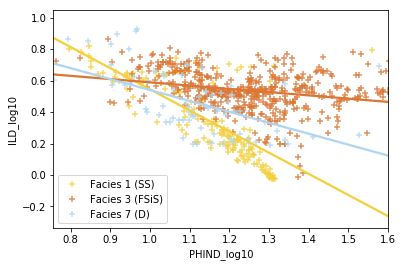

In [30]:
# -------------------------------------------------------------------
# Paper plot, use same color map as SEG machine learning competition
# -------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_xlim([0.7, 1.6])
#ax.set_ylim([-0.05, 1.50])
ax.set_xlabel('PHIND_log10')
ax.set_color_cycle([facies_colors[0]])
sns.regplot(pd.np.log10(df_facies_type_1['PHIND']), df_facies_type_1['ILD_log10'], marker='+', label='Facies 1 (SS)', ci=1)
ax.set_color_cycle([facies_colors[2]])
sns.regplot(pd.np.log10(df_facies_type_3['PHIND']), df_facies_type_3['ILD_log10'], marker='+', label='Facies 3 (FSiS)', ci=1)
ax.set_color_cycle([facies_colors[6]])
sns.regplot(pd.np.log10(df_facies_type_7['PHIND']), df_facies_type_7['ILD_log10'], marker='+', label='Facies 7 (D)', ci=1)
ax.set_xlabel('PHIND_log10')
ax.legend(loc='best')
fig.savefig('figures/logF_vs_logPhi_SEG.png', bbox_inches='tight')

#%matplotlib notebook
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
##ax.set_xlim([0.7, 1.6])
##ax.set_ylim([-0.05, 1.50])
#ax.set_xlabel('PHIND_log10')
#sns.regplot(pd.np.log10(df_facies_type_1['PHIND']), df_facies_type_1['ILD_log10'], marker='+', label='Facies 1', ci=1)
##sns.regplot(pd.np.log10(df_facies_type_2['PHIND']), df_facies_type_2['ILD_log10'], marker='+', label='Facies 2', ci=1)
#sns.regplot(pd.np.log10(df_facies_type_3['PHIND']), df_facies_type_3['ILD_log10'], marker='+', label='Facies 3', ci=1)
##ax = sns.regplot(pd.np.log10(df_facies_type_4['PHIND']), df_facies_type_4['ILD_log10'], marker='+', label='Facies 4', ci=1)
##sns.regplot(pd.np.log10(df_facies_type_5['PHIND']), df_facies_type_5['ILD_log10'], marker='+', label='Facies 5', ci=1)
##sns.regplot(pd.np.log10(df_facies_type_6['PHIND']), df_facies_type_6['ILD_log10'], marker='+', label='Facies 6', ci=1)
#sns.regplot(pd.np.log10(df_facies_type_7['PHIND']), df_facies_type_7['ILD_log10'], marker='+', label='Facies 7', ci=1)
##sns.regplot(pd.np.log10(df_facies_type_8['PHIND']), df_facies_type_8['ILD_log10'], marker='+', label='Facies 8', ci=1)
##sns.regplot(pd.np.log10(df_facies_type_9['PHIND']), df_facies_type_9['ILD_log10'], marker='+', label='Facies 9', ci=1)
#ax.set_xlabel('PHIND_log10')
#ax.legend(loc='best')

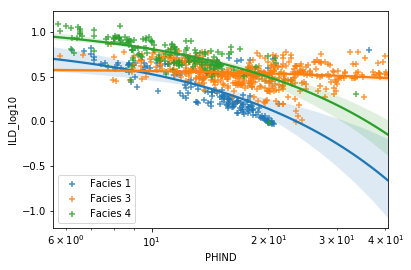

In [31]:
#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_xlim([0.7, 1.6])
#ax.set_ylim([-0.05, 1.50])
ax.set(xscale='log')
sns.regplot(df_facies_type_1['PHIND'], df_facies_type_1['ILD_log10'], marker='+', label='Facies 1')
#sns.regplot(df_facies_type_2['PHIND'], df_facies_type_2['ILD_log10'], marker='+', label='Facies 2')
sns.regplot(df_facies_type_3['PHIND'], df_facies_type_3['ILD_log10'], marker='+', label='Facies 3')
sns.regplot(df_facies_type_4['PHIND'], df_facies_type_4['ILD_log10'], marker='+', label='Facies 4')
#sns.regplot(df_facies_type_5['PHIND'], df_facies_type_5['ILD_log10'], marker='+', label='Facies 5')
#sns.regplot(df_facies_type_6['PHIND'], df_facies_type_6['ILD_log10'], marker='+', label='Facies 6')
#sns.regplot(df_facies_type_7['PHIND'], df_facies_type_7['ILD_log10'], marker='+', label='Facies 7')
#sns.regplot(df_facies_type_8['PHIND'], df_facies_type_8['ILD_log10'], marker='+', label='Facies 8')
#sns.regplot(df_facies_type_9['PHIND'], df_facies_type_9['ILD_log10'], marker='+', label='Facies 9')
ax.legend(loc='best')

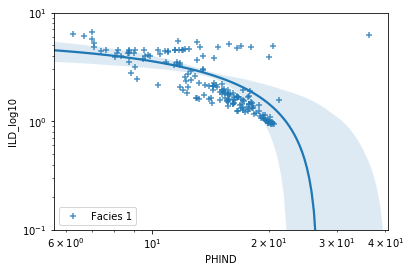

In [32]:
#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_xlim([0.7, 1.6])
ax.set_ylim([0.1, 10])
ax.set(xscale='log')
ax.set(yscale='log')
sns.regplot(df_facies_type_1['PHIND'], pd.np.power(10, df_facies_type_1['ILD_log10']), marker='+', label='Facies 1')
#sns.regplot(df_facies_type_2['PHIND'], df_facies_type_2['ILD_log10'], marker='+', label='Facies 2')
#sns.regplot(df_facies_type_3['PHIND'], df_facies_type_3['ILD_log10'], marker='+', label='Facies 3')
#sns.regplot(df_facies_type_4['PHIND'], df_facies_type_4['ILD_log10'], marker='+', label='Facies 4')
#sns.regplot(df_facies_type_5['PHIND'], df_facies_type_5['ILD_log10'], marker='+', label='Facies 5')
#sns.regplot(df_facies_type_6['PHIND'], df_facies_type_6['ILD_log10'], marker='+', label='Facies 6')
#sns.regplot(df_facies_type_7['PHIND'], df_facies_type_7['ILD_log10'], marker='+', label='Facies 7')
#sns.regplot(df_facies_type_8['PHIND'], df_facies_type_8['ILD_log10'], marker='+', label='Facies 8')
#sns.regplot(df_facies_type_9['PHIND'], df_facies_type_9['ILD_log10'], marker='+', label='Facies 9')
ax.legend(loc='best')

## ILD_log10 distribution

C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated

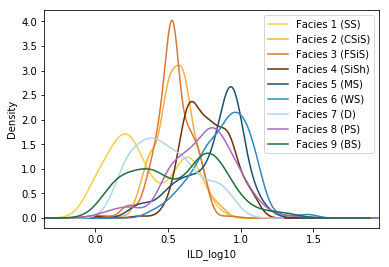

In [33]:
# -------------------------------------------------------------------
# Paper plot, use same color map as SEG machine learning competition
# -------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('ILD_log10')
ax.set_xlim([-0.35, 1.95])
ax.set_color_cycle([facies_colors[0]])
df_facies_type_1['ILD_log10'].plot(kind='density', label='Facies 1 (SS)')
ax.set_color_cycle([facies_colors[1]])
df_facies_type_2['ILD_log10'].plot(kind='density', label='Facies 2 (CSiS)')
ax.set_color_cycle([facies_colors[2]])
df_facies_type_3['ILD_log10'].plot(kind='density', label='Facies 3 (FSiS)')
ax.set_color_cycle([facies_colors[3]])
df_facies_type_4['ILD_log10'].plot(kind='density', label='Facies 4 (SiSh)')
ax.set_color_cycle([facies_colors[4]])
df_facies_type_5['ILD_log10'].plot(kind='density', label='Facies 5 (MS)')
ax.set_color_cycle([facies_colors[5]])
df_facies_type_6['ILD_log10'].plot(kind='density', label='Facies 6 (WS)')
ax.set_color_cycle([facies_colors[6]])
df_facies_type_7['ILD_log10'].plot(kind='density', label='Facies 7 (D)')
ax.set_color_cycle([facies_colors[7]])
df_facies_type_8['ILD_log10'].plot(kind='density', label='Facies 8 (PS)')
ax.set_color_cycle([facies_colors[8]])
df_facies_type_9['ILD_log10'].plot(kind='density', label='Facies 9 (BS)')
ax.legend(loc='best')
fig.savefig('figures/logF_9_facies_SEG.png', bbox_inches='tight')

## PHIND distribution

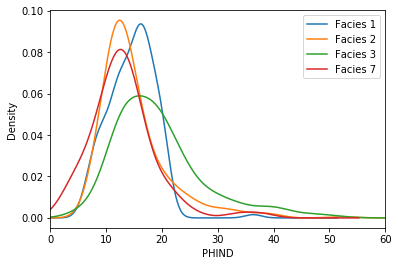

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PHIND')
ax.set_xlim([0, 60])
df_facies_type_1['PHIND'].plot(kind='density', label='Facies 1')
df_facies_type_2['PHIND'].plot(kind='density', label='Facies 2')
df_facies_type_3['PHIND'].plot(kind='density', label='Facies 3')
#df_facies_type_4['PHIND'].plot(kind='density', label='Facies 4')
#df_facies_type_5['PHIND'].plot(kind='density', label='Facies 5')
#df_facies_type_6['PHIND'].plot(kind='density', label='Facies 6')
df_facies_type_7['PHIND'].plot(kind='density', label='Facies 7')
#df_facies_type_8['PHIND'].plot(kind='density', label='Facies 8')
#df_facies_type_9['PHIND'].plot(kind='density', label='Facies 9')
ax.legend(loc='best')

## log10(PHIND) distribution

C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  
C:\Users\HomeUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated

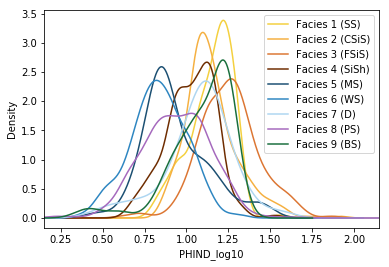

In [35]:
# -------------------------------------------------------------------
# Paper plot, use same color map as SEG machine learning competition
# -------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PHIND_log10')
ax.set_xlim([0.15, 2.15])
ax.set_color_cycle([facies_colors[0]])
pd.np.log10(df_facies_type_1['PHIND']).plot(kind='density', label='Facies 1 (SS)')
ax.set_color_cycle([facies_colors[1]])
pd.np.log10(df_facies_type_2['PHIND']).plot(kind='density', label='Facies 2 (CSiS)')
ax.set_color_cycle([facies_colors[2]])
pd.np.log10(df_facies_type_3['PHIND']).plot(kind='density', label='Facies 3 (FSiS)')
ax.set_color_cycle([facies_colors[3]])
pd.np.log10(df_facies_type_4['PHIND']).plot(kind='density', label='Facies 4 (SiSh)')
ax.set_color_cycle([facies_colors[4]])
pd.np.log10(df_facies_type_5['PHIND']).plot(kind='density', label='Facies 5 (MS)')
ax.set_color_cycle([facies_colors[5]])
pd.np.log10(df_facies_type_6['PHIND']).plot(kind='density', label='Facies 6 (WS)')
ax.set_color_cycle([facies_colors[6]])
pd.np.log10(df_facies_type_7['PHIND']).plot(kind='density', label='Facies 7 (D)')
ax.set_color_cycle([facies_colors[7]])
pd.np.log10(df_facies_type_8['PHIND']).plot(kind='density', label='Facies 8 (PS)')
ax.set_color_cycle([facies_colors[8]])
pd.np.log10(df_facies_type_9['PHIND']).plot(kind='density', label='Facies 9 (BS)')
ax.legend(loc='best')
fig.savefig('figures/logPhi_9_facies_SEG.png', bbox_inches='tight')

## ILD_log10/PHIND

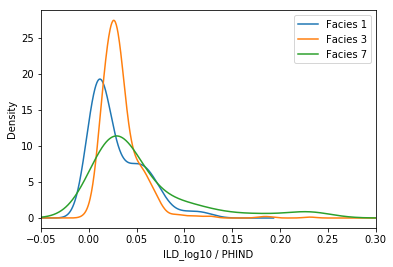

In [36]:
ratio_type_1 = df_facies_type_1['ILD_log10']/df_facies_type_1['PHIND']
ratio_type_2 = df_facies_type_2['ILD_log10']/df_facies_type_2['PHIND']
ratio_type_3 = df_facies_type_3['ILD_log10']/df_facies_type_3['PHIND']
ratio_type_4 = df_facies_type_4['ILD_log10']/df_facies_type_4['PHIND']

ratio_type_5 = df_facies_type_5['ILD_log10']/df_facies_type_5['PHIND']
ratio_type_6 = df_facies_type_6['ILD_log10']/df_facies_type_6['PHIND']
ratio_type_7 = df_facies_type_7['ILD_log10']/df_facies_type_7['PHIND']
ratio_type_8 = df_facies_type_8['ILD_log10']/df_facies_type_8['PHIND']
ratio_type_9 = df_facies_type_9['ILD_log10']/df_facies_type_9['PHIND']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('ILD_log10 / PHIND')
ax.set_xlim([-0.05, 0.3])
ratio_type_1.plot(kind='density', label='Facies 1')
#ratio_type_2.plot(kind='density', label='Facies 2')
ratio_type_3.plot(kind='density', label='Facies 3')
#ratio_type_4.plot(kind='density', label='Facies 4')
#ratio_type_5.plot(kind='density', label='Facies 5')
#ratio_type_6.plot(kind='density', label='Facies 6')
ratio_type_7.plot(kind='density', label='Facies 7')
#ratio_type_8.plot(kind='density', label='Facies 8')
#ratio_type_9.plot(kind='density', label='Facies 9')
ax.legend(loc='best')

## ILD_log10/PHIND_log10

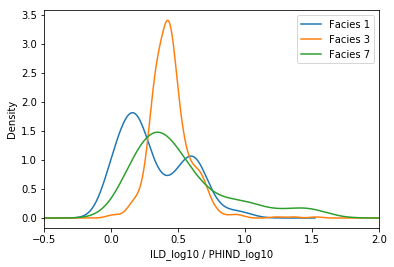

In [37]:
ratio_type_1 = df_facies_type_1['ILD_log10']/pd.np.log10(df_facies_type_1['PHIND'])
ratio_type_2 = df_facies_type_2['ILD_log10']/pd.np.log10(df_facies_type_2['PHIND'])
ratio_type_3 = df_facies_type_3['ILD_log10']/pd.np.log10(df_facies_type_3['PHIND'])
ratio_type_4 = df_facies_type_4['ILD_log10']/pd.np.log10(df_facies_type_4['PHIND'])

ratio_type_5 = df_facies_type_5['ILD_log10']/pd.np.log10(df_facies_type_5['PHIND'])
ratio_type_6 = df_facies_type_6['ILD_log10']/pd.np.log10(df_facies_type_6['PHIND'])
ratio_type_7 = df_facies_type_7['ILD_log10']/pd.np.log10(df_facies_type_7['PHIND'])
ratio_type_8 = df_facies_type_8['ILD_log10']/pd.np.log10(df_facies_type_8['PHIND'])
ratio_type_9 = df_facies_type_9['ILD_log10']/pd.np.log10(df_facies_type_9['PHIND'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('ILD_log10 / PHIND_log10')
ax.set_xlim([-0.5, 2.0])
ratio_type_1.plot(kind='density', label='Facies 1')
#ratio_type_2.plot(kind='density', label='Facies 2')
ratio_type_3.plot(kind='density', label='Facies 3')
#ratio_type_4.plot(kind='density', label='Facies 4')
#ratio_type_5.plot(kind='density', label='Facies 5')
#ratio_type_6.plot(kind='density', label='Facies 6')
ratio_type_7.plot(kind='density', label='Facies 7')
#ratio_type_8.plot(kind='density', label='Facies 8')
#ratio_type_9.plot(kind='density', label='Facies 9')
ax.legend(loc='best')

## ILD_log10 * PHIND

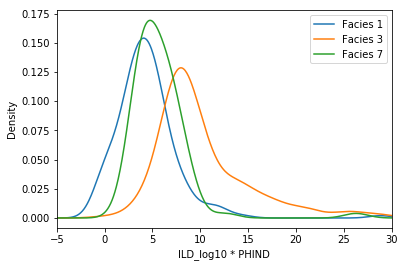

In [38]:
times_type_1 = df_facies_type_1['ILD_log10']*df_facies_type_1['PHIND']
times_type_2 = df_facies_type_2['ILD_log10']*df_facies_type_2['PHIND']
times_type_3 = df_facies_type_3['ILD_log10']*df_facies_type_3['PHIND']
times_type_4 = df_facies_type_4['ILD_log10']*df_facies_type_4['PHIND']

times_type_5 = df_facies_type_5['ILD_log10']*df_facies_type_5['PHIND']
times_type_6 = df_facies_type_6['ILD_log10']*df_facies_type_6['PHIND']
times_type_7 = df_facies_type_7['ILD_log10']*df_facies_type_7['PHIND']
times_type_8 = df_facies_type_8['ILD_log10']*df_facies_type_8['PHIND']
times_type_9 = df_facies_type_9['ILD_log10']*df_facies_type_9['PHIND']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('ILD_log10 * PHIND')
ax.set_xlim([-5, 30])
times_type_1.plot(kind='density', label='Facies 1')
#times_type_2.plot(kind='density', label='Facies 2')
times_type_3.plot(kind='density', label='Facies 3')
#times_type_4.plot(kind='density', label='Facies 4')
#times_type_5.plot(kind='density', label='Facies 5')
#times_type_6.plot(kind='density', label='Facies 6')
times_type_7.plot(kind='density', label='Facies 7')
#times_type_8.plot(kind='density', label='Facies 8')
#times_type_9.plot(kind='density', label='Facies 9')
ax.legend(loc='best')

## Plot measurement across different wells

In [66]:
data_raw = pd.read_csv('training_data.csv') 
data_raw['Well Name'].value_counts().sort_index()

CHURCHMAN BIBLE    404
CROSS H CATTLE     501
LUKE G U           461
NEWBY              463
NOLAN              415
Recruit F9          68
SHANKLE            449
SHRIMPLIN          471
Name: Well Name, dtype: int64

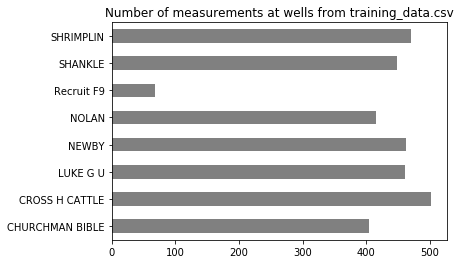

In [78]:
fig=plt.figure()

well_labels = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN',
                 'Recruit F9', 'SHANKLE','SHRIMPLIN']

measure_count = data_raw['Well Name'].value_counts().sort_index()
measure_count.index = well_labels

measure_count.plot(kind='barh',color='gray', 
                   title='Number of measurements at wells from training_data.csv')
#measure_count.plot(kind='barh',color=plt.cm.Blues, 
#                   title='Number of measurements at wells from training_data.csv')
fig.savefig('figures/measure_distribution_SEG.png', bbox_inches='tight')

# 7-fold cross-validation strategy

In [39]:
data[data['Well Name'] == 'SHA']

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ILDoLogPhi


In [40]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.signal import medfilt
from confusion_matrix_utilities import plot_confusion_matrix

data_raw = pd.read_csv('training_data.csv') 

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

# Store features and labels
X = data[feature_names].values  # features
y = data['Facies'].values  # labels

# Initialize model selection methods
lpgo = LeavePGroupsOut(1)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['NEWBY']
Split 1
    training:   ['SHRIMPLIN' nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['LUKE G U' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: [nan 'LUKE G U']
Split 3
    training:   ['SHRIMPLIN' nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'NEWBY']
    validation: ['NOLAN' 'Recruit F9' 'NEWBY']
Split 4
    training:   ['SHRIMPLIN' nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE']
Split 5
    training:   ['SHRIMPLIN' nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'NOLAN']
Split 6
    training:   [nan 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['SHRIMPLIN']


C:\Users\HomeUser\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [41]:
padded_rows

NameError: name 'padded_rows' is not defined

In [ ]:
# For each data split
score_split = []
conf_mat_all = []
for split in split_list:

    # Remove padded rows
    split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

    # Select training and validation data from current split
    X_tr = X_aug[split_train_no_pad, :]
    X_v = X_aug[split['val'], :]
    y_tr = y[split_train_no_pad]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]

    # Train and test
    y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v)

    # Score
    score = f1_score(y_v, y_v_hat, average='micro')
    score_split.append(score)
    conf_mat = confusion_matrix(y_v, y_v_hat, labels=np.arange(9)+1)
    conf_mat_all.append(conf_mat)
    
# Average scores
score_avg = np.mean(score_split)
print('\nAverage F1 score = %.3f' % score_avg)

# Confusion matrix
plot_confusion_matrix(np.sum(conf_mat_all, axis=0), classes=facies_names)